In [1]:
import sys
from pathlib import Path

# Add src directory to Python path
project_root = Path.cwd().parent
src_path = project_root / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))
    print(f"Added {src_path} to Python path")

Added /Users/cooper/Desktop/hydro-forecasting/src to Python path


In [2]:
import polars as pl
from sklearn.pipeline import Pipeline

from hydro_forecasting.data.caravanify_parquet import (
    CaravanifyParquet,
    CaravanifyParquetConfig,
)
from hydro_forecasting.data.in_memory_datamodule import HydroInMemoryDataModule
from hydro_forecasting.model_evaluation.evaluators import TSForecastEvaluator
from hydro_forecasting.model_evaluation.hp_from_yaml import hp_from_yaml
from hydro_forecasting.models.tide import LitTiDE, TiDEConfig
from hydro_forecasting.preprocessing.grouped import GroupedPipeline
from hydro_forecasting.preprocessing.normalize import NormalizeTransformer
from hydro_forecasting.preprocessing.standard_scale import StandardScaleTransformer

---

In [3]:
yaml_path = Path("/Users/cooper/Desktop/hydro-forecasting/notebooks/tide.yaml")

tide_hp = hp_from_yaml("tide", yaml_path)
tide_hp

{'decoder_output_size': 24,
 'dropout': 0.4040330172235821,
 'future_forcing_projection_size': 0,
 'future_input_size': 9,
 'group_identifier': 'gauge_id',
 'hidden_size': 110,
 'input_len': 34,
 'input_size': 10,
 'learning_rate': 0.00029399848560567596,
 'num_decoder_layers': 2,
 'num_encoder_layers': 2,
 'output_len': 10,
 'past_feature_projection_size': 0,
 'scheduler_factor': 0.5,
 'scheduler_patience': 5,
 'static_size': 10,
 'temporal_decoder_hidden_size': 51,
 'use_layer_norm': False}

In [4]:
config_ca = CaravanifyParquetConfig(
    attributes_dir="/Users/cooper/Desktop/CaravanifyParquet/CA/post_processed/attributes",
    timeseries_dir="/Users/cooper/Desktop/CaravanifyParquet/CA/post_processed/timeseries/csv",
    shapefile_dir="/Users/cooper/Desktop/CAMELS-CH/data/CARAVANIFY/CA/post_processed/shapefiles",
    gauge_id_prefix="CA",
    use_hydroatlas_attributes=True,
    use_caravan_attributes=True,
    use_other_attributes=True,
)

caravan_ca = CaravanifyParquet(config_ca)
basin_ids = caravan_ca.get_all_gauge_ids()[:50]

# basin_ids = [bid for bid in basin_ids if bid != "CA_15030"]

caravan_ca.load_stations(basin_ids)

In [5]:
config_us = CaravanifyParquetConfig(
    attributes_dir="/Users/cooper/Desktop/CaravanifyParquet/USA/post_processed/attributes",
    timeseries_dir="/Users/cooper/Desktop/CaravanifyParquet/USA/post_processed/timeseries/csv",
    shapefile_dir="/Users/cooper/Desktop/CAMELS-CH/data/CARAVANIFY/USA/post_processed/shapefiles",
    gauge_id_prefix="USA",
    use_hydroatlas_attributes=True,
    use_caravan_attributes=True,
    use_other_attributes=True,
)

caravan_us = CaravanifyParquet(config_us)
basin_ids += caravan_us.get_all_gauge_ids()[:50]

In [6]:
forcing_features = [
    "snow_depth_water_equivalent_mean",
    "surface_net_solar_radiation_mean",
    "surface_net_thermal_radiation_mean",
    "potential_evaporation_sum_ERA5_LAND",
    "potential_evaporation_sum_FAO_PENMAN_MONTEITH",
    "temperature_2m_mean",
    "temperature_2m_min",
    "temperature_2m_max",
    "total_precipitation_sum",
]

static_features = [
    "p_mean",
    "area",
    "ele_mt_sav",
    "high_prec_dur",
    "frac_snow",
    "high_prec_freq",
    "slp_dg_sav",
    "cly_pc_sav",
    "aridity_ERA5_LAND",
    "aridity_FAO_PM",
]

target = "streamflow"

In [7]:
feature_pipeline = GroupedPipeline(
    Pipeline([("scaler", StandardScaleTransformer()), ("normalizer", NormalizeTransformer())]),
    columns=forcing_features,
    group_identifier="gauge_id",
)

target_pipeline = GroupedPipeline(
    Pipeline([("scaler", StandardScaleTransformer()), ("normalizer", NormalizeTransformer())]),
    columns=["streamflow"],
    group_identifier="gauge_id",
)

static_pipeline = Pipeline([("scaler", StandardScaleTransformer())])

preprocessing_config = {
    "features": {"pipeline": feature_pipeline},
    "target": {"pipeline": target_pipeline},
    "static_features": {"pipeline": static_pipeline, "columns": static_features},
}

In [8]:
region_time_series_base_dirs = {
    "CA": "/Users/cooper/Desktop/CaravanifyParquet/CA/post_processed/timeseries/csv/CA",
    "USA": "/Users/cooper/Desktop/CaravanifyParquet/USA/post_processed/timeseries/csv/USA",
}

region_static_attributes_base_dirs = {
    "CA": "/Users/cooper/Desktop/CaravanifyParquet/CA/post_processed/attributes/CA",
    "USA": "/Users/cooper/Desktop/CaravanifyParquet/USA/post_processed/attributes/USA",
}

DATA_CHUNK_SIZE = 10

datamodule = HydroInMemoryDataModule(
    region_time_series_base_dirs=region_time_series_base_dirs,
    region_static_attributes_base_dirs=region_static_attributes_base_dirs,
    path_to_preprocessing_output_directory="/Users/cooper/Desktop/hydro-forecasting/tests/yolo_6",
    group_identifier="gauge_id",
    batch_size=2048,
    input_length=tide_hp["input_len"],
    output_length=tide_hp["output_len"],
    forcing_features=forcing_features,
    static_features=static_features,
    target=target,
    preprocessing_configs=preprocessing_config,
    num_workers=4,
    min_train_years=5,
    train_prop=0.5,
    val_prop=0.25,
    test_prop=0.25,
    max_imputation_gap_size=5,
    list_of_gauge_ids_to_process=basin_ids,
    is_autoregressive=True,
    chunk_size=DATA_CHUNK_SIZE,
    validation_chunk_size= 2 * DATA_CHUNK_SIZE,
)

datamodule.prepare_data()
datamodule.setup()

INFO:hydro_forecasting.data.in_memory_datamodule:Starting data preparation...
INFO:hydro_forecasting.data.in_memory_datamodule:Generated Run UUID for current config: 0d341a2f-a666-5857-9d89-0b60c95707e7
INFO:hydro_forecasting.data.in_memory_datamodule:Checking for existing processed data at: /Users/cooper/Desktop/hydro-forecasting/tests/yolo_6/0d341a2f-a666-5857-9d89-0b60c95707e7
INFO:hydro_forecasting.data.in_memory_datamodule:Successfully validated and prepared to reuse data from /Users/cooper/Desktop/hydro-forecasting/tests/yolo_6/0d341a2f-a666-5857-9d89-0b60c95707e7
INFO:hydro_forecasting.data.in_memory_datamodule:Reusing existing processed data from run_uuid: 0d341a2f-a666-5857-9d89-0b60c95707e7
INFO:hydro_forecasting.data.in_memory_datamodule:Loaded 3 pipelines and data for 99 basins from reused run.
INFO:hydro_forecasting.data.in_memory_datamodule:Found 99 basins for synchronized train/val chunking and validation pool selection.
INFO:hydro_forecasting.data.in_memory_datamodule:F

In [9]:
dataloader = datamodule.get_train_dataloader()

dataset = dataloader.dataset

INFO:hydro_forecasting.data.in_memory_datamodule:Epoch 0: Train Dataloader using chunk 1/10 with 10 basins.
INFO:hydro_forecasting.data.in_memory_datamodule:Stage 'train' chunk data loaded for 10 basins. Shape: (42408, 12). Est. Mem: 1.94 MB


In [10]:
dataset.chunk_column_tensors

{'date': tensor([1009929600000, 1010016000000, 1010102400000,  ...,
         1317081600000, 1317168000000, 1317254400000]),
 'potential_evaporation_sum_ERA5_LAND': tensor([-1.2826, -1.2696, -1.2826,  ...,  0.1321,  0.3081,  0.0929]),
 'potential_evaporation_sum_FAO_PENMAN_MONTEITH': tensor([-1.0960, -0.9191, -0.9481,  ...,  0.0303,  0.1984,  0.0391]),
 'snow_depth_water_equivalent_mean': tensor([ 0.1139,  0.1136,  0.1133,  ..., -1.2808, -1.2618, -1.2561]),
 'streamflow': tensor([-1.4014, -1.4014, -1.4014,  ..., -0.5880, -0.6128, -0.6128]),
 'surface_net_solar_radiation_mean': tensor([-1.2061, -1.2068, -1.2229,  ...,  0.3821,  0.4284,  0.3001]),
 'surface_net_thermal_radiation_mean': tensor([ 0.3136,  0.6098,  0.9062,  ..., -0.7012, -0.5784, -0.4888]),
 'temperature_2m_max': tensor([-0.9561, -0.8263, -0.6625,  ...,  0.4716,  0.6380,  0.5600]),
 'temperature_2m_mean': tensor([-0.9143, -0.7831, -0.6220,  ...,  0.4803,  0.5445,  0.5779]),
 'temperature_2m_min': tensor([-0.7392, -0.5691, -0

## Verify static data

In [11]:
# test_dataset = datamodule.test_dataset
# if not test_dataset:
#     print("Test dataset not found.")
# elif len(test_dataset) == 0:
#     print("Test dataset is empty.")
# else:
#     print(f"Test dataset size: {len(test_dataset)}")
#     # --- Get a Sample ---
#     sample_index = 1654
#     print(f"Getting sample at index {sample_index}...")
#     try:
#         sample = test_dataset[sample_index]

#         # --- Check for NaNs in the Sample Tensors ---
#         print("\n--- Checking for NaNs in sample tensors ---")
#         for key, tensor in sample.items():
#             if isinstance(tensor, torch.Tensor):
#                 has_nan = torch.isnan(tensor).any().item()
#                 print(f"Tensor'{key}' shape: {tensor.shape}, Contains NaNs: {has_nan}")
#                 print(f"  Sample tensor '{key}': {tensor[:5]}")
#                 if has_nan:
#                     # Optional: Print where NaNs occur
#                     nan_indices = torch.nonzero(torch.isnan(tensor))
#                     print(f"  NaN indices in '{key}': {nan_indices.tolist()[:5]}...") # Print first 5
#             else:
#                 print(f"Item '{key}' is not a tensor (type: {type(tensor)})")

#     except IndexError:
#         print(f"Error: Index {sample_index} out of bounds for dataset size {len(test_dataset)}")
#     except Exception as e:
#         print(f"An error occurred while getting or checking the sample: {e}")

In [12]:
# ie = datamodule.val_index_entries[1661]

# file_path = ie["file_path"]
# start_idx = ie["start_idx"]
# end_idx = ie["end_idx"]
# gauge_id = ie["gauge_id"]

# data = pd.read_parquet(file_path)

# # Slice the data
# data_slice = data.iloc[start_idx:end_idx]
# print(f"Data slice shape: {data_slice.shape}")

# data_slice["streamflow"]

## Let's try training a model

In [13]:
input_length = datamodule.input_length
output_length = datamodule.output_length

config = TiDEConfig(**tide_hp)


# Instantiate the Lightning module.
model = LitTiDE(config)

In [14]:
import pytorch_lightning as pl

trainer = pl.Trainer(max_epochs=5, accelerator="gpu", devices=1, reload_dataloaders_every_n_epochs=True)

# Train the model
trainer.fit(model, datamodule)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
INFO:hydro_forecasting.data.in_memory_datamodule:Data preparation has already run.

  | Name          | Type      | Params | Mode 
----------------------------------------------------
0 | mse_criterion | MSELoss   | 0      | train
1 | model         | TiDEModel | 250 K  | train
----------------------------------------------------
250 K     Trainable params
0         Non-trainable params
250 K     Total params
1.001     Total estimated model params size (MB)
40        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO:hydro_forecasting.data.in_memory_datamodule:Epoch 0: Val Dataloader using cached validation data with 47748 samples from 20 basins.
/Users/cooper/Desktop/hydro-forecasting/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: The combination of `DataLoader(`pin_memory=True`, `persistent_workers=True`) and `Trainer(reload_dataloaders_every_n_epochs > 0)` can lead to instability due to limitations in PyTorch (https://github.com/pytorch/pytorch/issues/91252). We recommend setting `pin_memory=False` in this case.
/Users/cooper/Desktop/hydro-forecasting/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


INFO:hydro_forecasting.data.in_memory_datamodule:Epoch 0: Train Dataloader using chunk 2/10 with 10 basins.
INFO:hydro_forecasting.data.in_memory_datamodule:Stage 'train' chunk data loaded for 10 basins. Shape: (47824, 12). Est. Mem: 2.19 MB


/Users/cooper/Desktop/hydro-forecasting/.venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (24) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 24/24 [00:04<00:00,  5.05it/s, v_num=119]

INFO:hydro_forecasting.data.in_memory_datamodule:Epoch 1: Train Dataloader using chunk 3/10 with 10 basins.
INFO:hydro_forecasting.data.in_memory_datamodule:Stage 'train' chunk data loaded for 10 basins. Shape: (42727, 12). Est. Mem: 1.96 MB


Epoch 1:   0%|          | 0/21 [00:00<?, ?it/s, v_num=119]         

/Users/cooper/Desktop/hydro-forecasting/.venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 1: 100%|██████████| 21/21 [00:01<00:00, 11.18it/s, v_num=119]

INFO:hydro_forecasting.data.in_memory_datamodule:Epoch 1: Val Dataloader using cached validation data with 47748 samples from 20 basins.


Epoch 1: 100%|██████████| 21/21 [00:05<00:00,  3.81it/s, v_num=119]

INFO:hydro_forecasting.data.in_memory_datamodule:Epoch 2: Train Dataloader using chunk 4/10 with 10 basins.
INFO:hydro_forecasting.data.in_memory_datamodule:Stage 'train' chunk data loaded for 10 basins. Shape: (51167, 12). Est. Mem: 2.34 MB


Epoch 2:   0%|          | 0/25 [00:00<?, ?it/s, v_num=119]         

/Users/cooper/Desktop/hydro-forecasting/.venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 2: 100%|██████████| 25/25 [00:01<00:00, 16.62it/s, v_num=119]

INFO:hydro_forecasting.data.in_memory_datamodule:Epoch 2: Val Dataloader using cached validation data with 47748 samples from 20 basins.


Epoch 2: 100%|██████████| 25/25 [00:05<00:00,  4.78it/s, v_num=119]

INFO:hydro_forecasting.data.in_memory_datamodule:Epoch 3: Train Dataloader using chunk 5/10 with 10 basins.
INFO:hydro_forecasting.data.in_memory_datamodule:Stage 'train' chunk data loaded for 10 basins. Shape: (45863, 12). Est. Mem: 2.10 MB


Epoch 3:   0%|          | 0/23 [00:00<?, ?it/s, v_num=119]         

/Users/cooper/Desktop/hydro-forecasting/.venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 3: 100%|██████████| 23/23 [00:01<00:00, 18.06it/s, v_num=119]

INFO:hydro_forecasting.data.in_memory_datamodule:Epoch 3: Val Dataloader using cached validation data with 47748 samples from 20 basins.


Epoch 3: 100%|██████████| 23/23 [00:05<00:00,  4.48it/s, v_num=119]

INFO:hydro_forecasting.data.in_memory_datamodule:Epoch 4: Train Dataloader using chunk 6/10 with 10 basins.
INFO:hydro_forecasting.data.in_memory_datamodule:Stage 'train' chunk data loaded for 10 basins. Shape: (45558, 12). Est. Mem: 2.09 MB


Epoch 4: 100%|██████████| 23/23 [00:01<00:00, 15.22it/s, v_num=119]

INFO:hydro_forecasting.data.in_memory_datamodule:Epoch 4: Val Dataloader using cached validation data with 47748 samples from 20 basins.


Epoch 4: 100%|██████████| 23/23 [00:05<00:00,  4.30it/s, v_num=119]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 23/23 [00:05<00:00,  4.27it/s, v_num=119]


In [15]:
models_and_datamodules = {
    "TiDE": (model, datamodule),
}

evaluator = TSForecastEvaluator(
    horizons=list(range(1, output_length + 1)),
    models_and_datamodules=models_and_datamodules,
    trainer_kwargs={
        "accelerator": "cpu",
        "devices": 1,
        # "reload_dataloaders_every_epoch": True,
    },
)

In [16]:
results = evaluator.test_models()

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/cooper/Desktop/hydro-forecasting/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:hydro_forecasting.data.in_memory_datamodule:Data preparation has already run.
INFO:hydro_forecasting.data.in_memory_datamodule:Loading test data for 99 basins...
INFO:hydro_forecasting.data.in_memory_datamodule:Stage 'test' chunk data loaded for 99 basins. Shape: (231854, 12). Est. Mem: 10.61 MB


Testing TiDE...
Testing DataLoader 0: 100%|██████████| 112/112 [00:02<00:00, 40.54it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.1269615739583969
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [17]:
df = results["TiDE"]["df"]

In [18]:
df

horizon,prediction,observed,basin_id,date
i32,f32,f32,str,datetime[μs]
1,-0.329153,-0.443791,"""USA_01054200""",2018-01-05 00:00:00
2,-0.082337,-0.46142,"""USA_01054200""",2018-01-06 00:00:00
3,-0.57764,-0.47902,"""USA_01054200""",2018-01-07 00:00:00
4,-0.497297,-0.496594,"""USA_01054200""",2018-01-08 00:00:00
5,-0.372802,-0.496594,"""USA_01054200""",2018-01-09 00:00:00
…,…,…,…,…
6,0.338795,0.432143,"""CA_15287""",2014-12-05 00:00:00
7,0.381125,0.432143,"""CA_15287""",2014-12-06 00:00:00
8,0.408092,0.432143,"""CA_15287""",2014-12-07 00:00:00


In [19]:
unique_ids = df["basin_id"].unique().to_list()
unique_ids

['CA_16100',
 'CA_15283',
 'CA_16127',
 'USA_01052500',
 'USA_01031500',
 'USA_01055000',
 'USA_01057000',
 'USA_01415000',
 'CA_16134',
 'CA_15090',
 'USA_01118300',
 'CA_15215',
 'USA_01491000',
 'USA_01013500',
 'CA_16143',
 'USA_01078000',
 'CA_15022',
 'USA_01451800',
 'CA_16101',
 'CA_15020',
 'USA_01365000',
 'CA_15045',
 'USA_01123000',
 'CA_15069',
 'USA_01022500',
 'CA_15054',
 'CA_16059',
 'CA_15259',
 'USA_01516500',
 'USA_01466500',
 'USA_01121000',
 'CA_16068',
 'USA_01350000',
 'CA_15278',
 'USA_01195100',
 'USA_01440400',
 'CA_15285',
 'CA_15013',
 'CA_15040',
 'USA_01142500',
 'USA_01435000',
 'CA_15081',
 'CA_16139',
 'CA_15256',
 'USA_01137500',
 'USA_01170100',
 'CA_15194',
 'CA_15214',
 'USA_01413500',
 'USA_01486000',
 'CA_15025',
 'CA_15070',
 'CA_15189',
 'CA_16055',
 'USA_01181000',
 'CA_15212',
 'CA_16070',
 'USA_01350080',
 'USA_01139800',
 'USA_01162500',
 'CA_15049',
 'USA_01047000',
 'USA_01434025',
 'USA_01187300',
 'CA_15171',
 'CA_15044',
 'USA_01440000

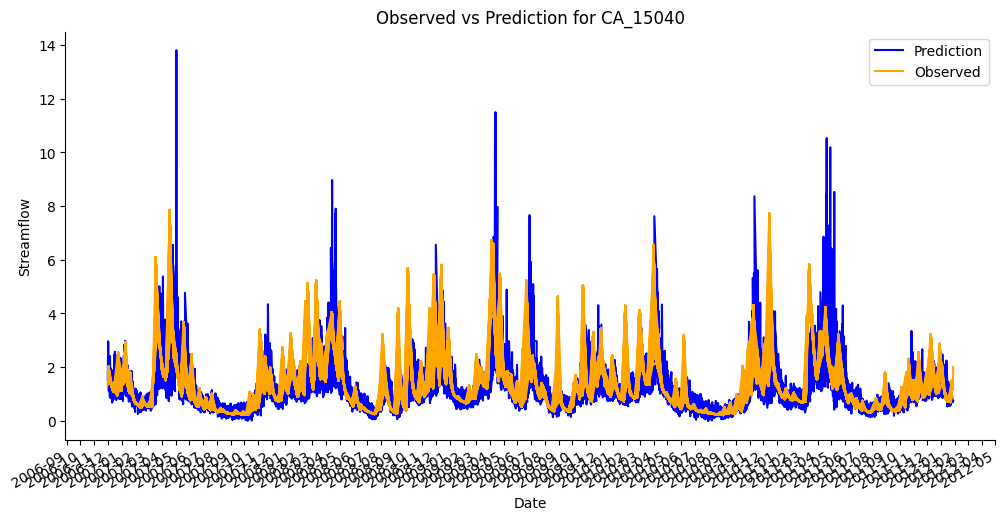

In [22]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns

# Define the basin ID to filter
basin_id = "CA_15040"

# Filter the dataframe using polars syntax
df_basin = df.filter(pl.col("basin_id") == basin_id)

# Convert to pandas for plotting (optional, but sometimes easier with matplotlib)
# Alternatively, you can use the polars values directly as shown below
# df_basin_pd = df_basin.to_pandas()

# Create the plot
plt.figure(figsize=(12, 6))

# Use  to access the column values for plotting
plt.plot(df_basin["date"], df_basin["prediction"], label="Prediction", color="blue")
plt.plot(df_basin["date"], df_basin["observed"], label="Observed", color="orange")

# Add title and labels
plt.title(f"Observed vs Prediction for {basin_id}")
plt.xlabel("Date")
plt.ylabel("Streamflow")
plt.legend()

# Format the x-axis for dates
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.gcf().autofmt_xdate()

# Remove the top and right spines
sns.despine()

# Show the plot
plt.show()